In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
# We might use OneHotEncoder or get_dummies later for some categorical features
# from sklearn.preprocessing import OneHotEncoder
# For text features, if we use them:
# from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility, if desired
# np.random.seed(42)
# torch.manual_seed(42)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(42)

In [4]:
# --- Configuration ---
DATA_DIR = './' # Assuming your data is in the same directory as the notebook
TRAIN_FILE = 'train.csv' # Replace with your actual training file name if different
TEST_FILE = 'test.csv'   # Replace with your actual test file name if different

# Model Hyperparameters (we'll refine these later)
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 20 # Start with a smaller number for initial runs, e.g., 10-20

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
# Load the datasets
try:
    train_df = pd.read_csv(f"{DATA_DIR}{TRAIN_FILE}")
    test_df = pd.read_csv(f"{DATA_DIR}{TEST_FILE}")
except FileNotFoundError:
    print(f"Ensure your data files ('{TRAIN_FILE}', '{TEST_FILE}') are in the directory: {DATA_DIR}")
    print("You can download them from: https://www.kaggle.com/competitions/patient-class-prediction/data")
    # Stop execution or handle error appropriately if files are not found
    raise

# Display basic information and a few rows
print("--- Training Data ---")
train_df.info()
print("\nFirst 5 rows of Training Data:")
print(train_df.head())

print("\n\n--- Test Data ---")
test_df.info()
print("\nFirst 5 rows of Test Data:")
print(test_df.head())

# Store PatientIDs from test set for later submission file creation
# We will need this to create our submission file in the format: PatientID,Predicted_Admission_Category
test_patient_ids = test_df['PatientID']
print(f"\nStored {len(test_patient_ids)} PatientIDs from the test set for submission.")

--- Training Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PatientID              20000 non-null  object 
 1   Street                 8000 non-null   object 
 2   Location               18000 non-null  object 
 3   Latitude               20000 non-null  float64
 4   Longitude              20000 non-null  float64
 5   Admission_Type         20000 non-null  object 
 6   Discharge_Disposition  20000 non-null  object 
 7   Admission_Date         20000 non-null  object 
 8   Discharge_Date         20000 non-null  object 
 9   Length_of_Stay         20000 non-null  int64  
 10  Age                    20000 non-null  int64  
 11  Gender                 20000 non-null  object 
 12  Ethnicity              20000 non-null  object 
 13  Primary_Diagnosis      20000 non-null  object 
 14  Secondary_Diagnosis    20000 non

--- Target Variable: Admission_Category ---

Distribution of Admission Categories:
Admission_Category
Urgent       12057
Newborn       4300
Emergency     2620
Elective      1023
Name: count, dtype: int64

Percentage Distribution of Admission Categories:
Admission_Category
Urgent       60.285
Newborn      21.500
Emergency    13.100
Elective      5.115
Name: proportion, dtype: float64


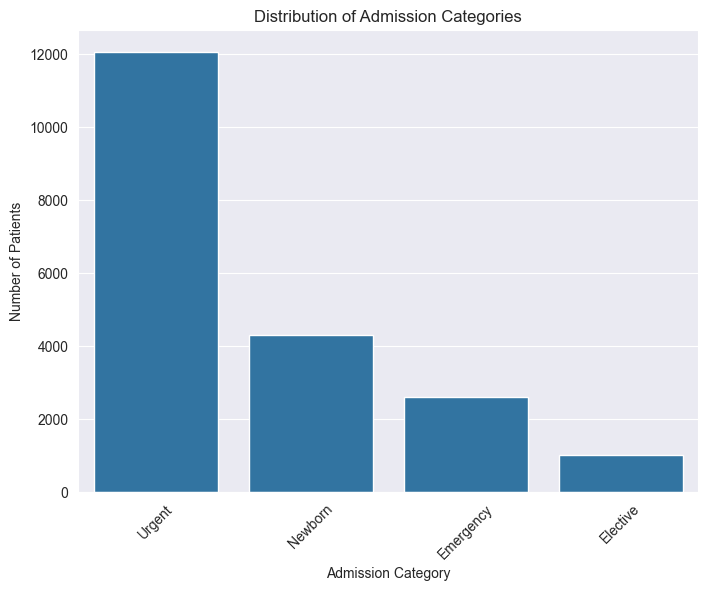

In [5]:
print("--- Target Variable: Admission_Category ---")

# Value counts
print("\nDistribution of Admission Categories:")
admission_category_counts = train_df['Admission_Category'].value_counts()
print(admission_category_counts)

# Percentage distribution
print("\nPercentage Distribution of Admission Categories:")
admission_category_percentage = train_df['Admission_Category'].value_counts(normalize=True) * 100
print(admission_category_percentage)

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='Admission_Category', order=admission_category_counts.index)
plt.title('Distribution of Admission Categories')
plt.ylabel('Number of Patients')
plt.xlabel('Admission Category')
plt.xticks(rotation=45)
plt.show()

In [7]:
print("--- Feature Analysis and Preprocessing Plan ---")

# Display column names and their data types again for reference
print("Columns and Data Types from train_df.info():")
train_df.info()

# --- Our Initial Plan ---

# 1. Target Variable: 'Admission_Category'
#    - Already analyzed. Will be LabelEncoded.

# 2. Identifier Columns:
#    - 'PatientID': Will be dropped from features used for training. Kept for test_df for submission.
#    - 'Street', 'Location': These are high cardinality text/categorical.
#      Initial thought: Drop them as they might be too complex for an initial model (or require advanced NLP/geospatial feature engineering).
#      Alternative: Could explore frequency encoding or target encoding later if simpler models don't perform well.

# 3. Numerical Features:
#    - Examples from dataset: 'Latitude', 'Longitude', 'Length_of_Stay', 'Age' (plus others identified as numeric).
#    - Preprocessing:
#        - Handle missing values (e.g., impute with median or mean).
#        - Scale/Standardize (e.g., using StandardScaler).

# 4. Categorical Features:
#    - Low Cardinality (few unique values):
#        - Examples: 'Gender', 'Comorbidities', 'Follow_Up', 'Insurance' (and 'Admission_Type' if it's different from target).
#        - Preprocessing:
#            - Handle missing values (e.g., impute with mode or a special "Missing" category).
#            - One-Hot Encode or use Embedding Layers. Given we're using PyTorch, nn.Embedding is very flexible.
#    - High Cardinality (many unique values):
#        - Examples: 'Primary_Diagnosis', 'Secondary_Diagnosis', 'Procedure_Code', 'Ethnicity', 'Discharge_Disposition', 'Medication'
#        - Preprocessing:
#            - Handle missing values.
#            - LabelEncode each category into integers, then use nn.Embedding layers in the PyTorch model. This is generally better than one-hot encoding for high cardinality.

# 5. Date Features:
#    - Examples: 'Admission_Date', 'Discharge_Date'.
#    - Preprocessing:
#        - Convert to datetime objects.
#        - Extract useful components: year, month, day of week, day of year, duration between dates (if not already captured by 'Length_of_Stay').
#        - These extracted features will then be treated as numerical or categorical.

# 6. Text Features:
#    - Examples: 'Procedure_Description', 'Notes', 'Doctor_Comments' (and potentially 'Primary_Diagnosis', 'Secondary_Diagnosis' if not treated as high-cardinality categorical).
#    - Preprocessing:
#        - Initial thought for simplicity: Use TF-IDF vectorization on one or a combination of these, limiting the number of features (e.g., top 100-500 TF-IDF terms).
#        - More advanced: Word embeddings (Word2Vec, GloVe, FastText) followed by RNNs/LSTMs or 1D CNNs, or pre-trained transformers. (Let's start simpler).
#        - These will likely need careful handling of missing/NaN values (e.g., replace with an empty string before vectorization).

print("\nThis cell is primarily for planning. Actual preprocessing will be done in subsequent cells.")

--- Feature Analysis and Preprocessing Plan ---
Columns and Data Types from train_df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PatientID              20000 non-null  object 
 1   Street                 8000 non-null   object 
 2   Location               18000 non-null  object 
 3   Latitude               20000 non-null  float64
 4   Longitude              20000 non-null  float64
 5   Admission_Type         20000 non-null  object 
 6   Discharge_Disposition  20000 non-null  object 
 7   Admission_Date         20000 non-null  object 
 8   Discharge_Date         20000 non-null  object 
 9   Length_of_Stay         20000 non-null  int64  
 10  Age                    20000 non-null  int64  
 11  Gender                 20000 non-null  object 
 12  Ethnicity              20000 non-null  object 
 13  Primary_Diagn

In [8]:
print("--- Preprocessing Target Variable: Admission_Category ---")

# Initialize LabelEncoder
target_label_encoder = LabelEncoder()

# Fit on the training data's target variable and transform it
train_df['Admission_Category_Encoded'] = target_label_encoder.fit_transform(train_df['Admission_Category'])

# Display the mapping
print("\nMapping of original categories to encoded labels:")
for i, class_name in enumerate(target_label_encoder.classes_):
    print(f"{class_name}: {i}")

# Check the first few rows with the new encoded column
print("\nTraining data with encoded target variable (first 5 rows):")
print(train_df[['PatientID', 'Admission_Category', 'Admission_Category_Encoded']].head())

# We'll use 'Admission_Category_Encoded' as our 'y' for training.
y_labels = train_df['Admission_Category_Encoded'].values
num_classes = len(target_label_encoder.classes_)
print(f"\nNumber of unique classes: {num_classes}")

--- Preprocessing Target Variable: Admission_Category ---

Mapping of original categories to encoded labels:
Elective: 0
Emergency: 1
Newborn: 2
Urgent: 3

Training data with encoded target variable (first 5 rows):
                              PatientID Admission_Category  \
0  624c2f33-ddee-4cec-b3af-6b066c9460ac             Urgent   
1  7d4fa4db-d71c-477c-b82a-1c6f87e4cc5c            Newborn   
2  12a1fe7d-dfa5-4722-8a1f-c9df9a591974             Urgent   
3  92abe1cb-7f1f-4b30-855f-9ac0a1a5366b             Urgent   
4  69fb0763-8a9c-46f7-8ee4-e5125802b640             Urgent   

   Admission_Category_Encoded  
0                           3  
1                           2  
2                           3  
3                           3  
4                           3  

Number of unique classes: 4


In [10]:
print("--- Handling Identifiers and Initial Feature Drops ---")

# Columns to drop for training
# PatientID is an identifier.
# Street and Location are complex free-text/categorical, dropping for initial model simplicity.
# Admission_Category is our original target, we now have Admission_Category_Encoded.

cols_to_drop = ['PatientID', 'Admission_Category', 'Street', 'Location']

# Drop from training dataframe
train_features_df = train_df.drop(columns=cols_to_drop, errors='ignore')
print(f"\nDropped columns from training data: {cols_to_drop}")
print(f"Remaining training columns: {train_features_df.columns.tolist()}")

# Drop from test dataframe (PatientID is already saved, Admission_Category won't exist in test)
test_features_df = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns and col != 'PatientID'], errors='ignore')
# We keep PatientID in test_df for now, but will remove it from features supplied to the model.
# For features, we use test_features_df which will have PatientID removed if it was in cols_to_drop for features.
# A bit convoluted here, let's simplify:
# We want train_features_df and test_features_df to have the same columns (except target in test)

# Re-aligning the drop for clarity
train_features_df = train_df.drop(columns=['PatientID', 'Admission_Category', 'Street', 'Location'], errors='ignore')
test_features_df = test_df.drop(columns=['Street', 'Location'], errors='ignore') # PatientID is kept in test_df but not used as a feature. Admission_Category is not in test_df.

print(f"\nShape of training features: {train_features_df.shape}")
print(f"Shape of test features: {test_features_df.shape}") # PatientID is still here

# Display current columns
print("\nTraining feature columns:")
print(train_features_df.columns.tolist())
print("\nTest feature columns (PatientID still present, will be excluded from model input):")
print(test_features_df.columns.tolist())

--- Handling Identifiers and Initial Feature Drops ---

Dropped columns from training data: ['PatientID', 'Admission_Category', 'Street', 'Location']
Remaining training columns: ['Latitude', 'Longitude', 'Admission_Type', 'Discharge_Disposition', 'Admission_Date', 'Discharge_Date', 'Length_of_Stay', 'Age', 'Gender', 'Ethnicity', 'Primary_Diagnosis', 'Secondary_Diagnosis', 'Procedure_Code', 'Procedure_Description', 'Comorbidities', 'Medication', 'Follow_Up', 'Insurance', 'Notes', 'Doctor_Comments', 'Medication_Details', 'Admission_Category_Encoded']

Shape of training features: (20000, 22)
Shape of test features: (5000, 23)

Training feature columns:
['Latitude', 'Longitude', 'Admission_Type', 'Discharge_Disposition', 'Admission_Date', 'Discharge_Date', 'Length_of_Stay', 'Age', 'Gender', 'Ethnicity', 'Primary_Diagnosis', 'Secondary_Diagnosis', 'Procedure_Code', 'Procedure_Description', 'Comorbidities', 'Medication', 'Follow_Up', 'Insurance', 'Notes', 'Doctor_Comments', 'Medication_Detai

In [11]:
print("--- Processing Date Features ---")

# Identify date columns (based on Kaggle data description)
# Common date columns in such datasets: 'Admission_Date', 'Discharge_Date'
# Verify these column names from your train_df.info() output if different.
date_cols = ['Admission_Date', 'Discharge_Date'] # Adjust if your column names are different

for df in [train_features_df, test_features_df]:
    for col in date_cols:
        if col in df.columns:
            print(f"Processing date column: {col} in {'training' if df is train_features_df else 'test'} data")
            df[col] = pd.to_datetime(df[col], errors='coerce') # 'coerce' will turn unparseable dates into NaT (Not a Time)

            # Extract features
            df[col + '_Year'] = df[col].dt.year
            df[col + '_Month'] = df[col].dt.month
            df[col + '_Day'] = df[col].dt.day
            df[col + '_DayOfWeek'] = df[col].dt.dayofweek # Monday=0, Sunday=6
            df[col + '_DayOfYear'] = df[col].dt.dayofyear
            # df[col + '_WeekOfYear'] = df[col].dt.isocalendar().week.astype(int) # Alternative way to get week

            # Drop the original date column
            df.drop(columns=[col], inplace=True)
        else:
            print(f"Warning: Date column '{col}' not found in {'training' if df is train_features_df else 'test'} data. Skipping.")

# Optional: Calculate duration if relevant and not already present
# For example, if 'Length_of_Stay' was not available, we could calculate it.
# Since 'Length_of_Stay' is a feature, we might not need to explicitly calculate it here,
# but ensure 'Discharge_Date' derived features are handled carefully if they create leakage for rows
# where discharge hasn't happened yet (though this is usually more relevant for predicting future events).
# For now, we assume 'Length_of_Stay' is the primary source for stay duration.

print("\n--- Training features after date processing (first 5 rows) ---")
print(train_features_df.head())
print(f"\nShape of training features: {train_features_df.shape}")

print("\n--- Test features after date processing (first 5 rows) ---")
# Temporarily drop PatientID for head() display if it makes it too wide, but it's still in test_features_df
print(test_features_df.drop(columns=['PatientID'], errors='ignore').head())
print(f"\nShape of test features: {test_features_df.shape}")

# Verify new columns
print("\nNew date-derived columns in training data:")
new_date_cols_train = [col for col in train_features_df.columns if any(dc in col for dc in date_cols)]
print(new_date_cols_train)

--- Processing Date Features ---
Processing date column: Admission_Date in training data
Processing date column: Discharge_Date in training data
Processing date column: Admission_Date in test data
Processing date column: Discharge_Date in test data

--- Training features after date processing (first 5 rows) ---
    Latitude   Longitude Admission_Type            Discharge_Disposition  \
0  35.433998 -117.814557      Emergency  Transferred to another hospital   
1  34.144074 -117.359235        Newborn      Left against medical advice   
2  35.394841 -117.372186       Elective     Discharged to rehabilitation   
3  34.822082 -117.494405       Elective     Discharged to rehabilitation   
4  34.545248 -117.210027         Urgent               Discharged to home   

   Length_of_Stay  Age Gender Ethnicity Primary_Diagnosis Secondary_Diagnosis  \
0              24   80  Other     Asian               D04                 B07   
1              10   69   Male     Asian               E05           

In [12]:
print("--- Handling Missing Values (Corrected) ---")

# Ensure target variable is not in features
if 'Admission_Category_Encoded' in train_features_df.columns:
    print("Removing 'Admission_Category_Encoded' (target variable) from train_features_df.")
    train_features_df = train_features_df.drop(columns=['Admission_Category_Encoded'])

# Treat 'Procedure_Code' as categorical: convert to object type first
# This ensures it's not imputed with median and will be handled by categorical imputation/encoding
for df in [train_features_df, test_features_df]:
    if 'Procedure_Code' in df.columns:
        df['Procedure_Code'] = df['Procedure_Code'].astype(str) # Convert to string/object
        # If NaNs were actual numbers and became "nan" string, that's fine,
        # the categorical imputer will catch it.

# Re-identify numerical and categorical columns
numerical_cols = train_features_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_features_df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nIdentified numerical columns for imputation: {numerical_cols}")
print(f"Identified categorical columns for imputation: {categorical_cols}")

# Impute Numerical Features with Median (from training data)
print("\nImputing numerical features with median:")
for col in numerical_cols:
    if train_features_df[col].isnull().any():
        median_val = train_features_df[col].median()
        train_features_df[col] = train_features_df[col].fillna(median_val) # Corrected fillna
        if col in test_features_df.columns:
            test_features_df[col] = test_features_df[col].fillna(median_val) # Corrected fillna
        print(f"  Imputed numerical column '{col}' with median: {median_val}")

# Impute Categorical Features with "Missing" (from training data)
print("\nImputing categorical features with 'Missing':")
for col in categorical_cols:
    if train_features_df[col].isnull().any():
        fill_value = "Missing"
        train_features_df[col] = train_features_df[col].fillna(fill_value) # Corrected fillna
        if col in test_features_df.columns:
            test_features_df[col] = test_features_df[col].fillna(fill_value) # Corrected fillna
        print(f"  Imputed categorical column '{col}' with '{fill_value}'")

# Verify missing values again
print("\nMissing values in training features after imputation:")
print(train_features_df.isnull().sum().sum())

print("\nMissing values in test features after imputation:")
common_cols_for_nan_check = [col for col in test_features_df.columns if col in train_features_df.columns]
print(test_features_df[common_cols_for_nan_check].isnull().sum().sum())

print("\n--- Training features after corrected missing value imputation (first 5 rows) ---")
print(train_features_df.head())
print(f"\nShape of training features: {train_features_df.shape}")

print("\n--- Test features after corrected missing value imputation (first 5 rows) ---")
# PatientID is still in test_features_df but won't be used as a model input feature.
print(test_features_df.drop(columns=['PatientID'], errors='ignore').head())
print(f"\nShape of test features: {test_features_df.shape}")

--- Handling Missing Values (Corrected) ---
Removing 'Admission_Category_Encoded' (target variable) from train_features_df.

Identified numerical columns for imputation: ['Latitude', 'Longitude', 'Length_of_Stay', 'Age', 'Admission_Date_Year', 'Admission_Date_Month', 'Admission_Date_Day', 'Admission_Date_DayOfWeek', 'Admission_Date_DayOfYear', 'Discharge_Date_Year', 'Discharge_Date_Month', 'Discharge_Date_Day', 'Discharge_Date_DayOfWeek', 'Discharge_Date_DayOfYear']
Identified categorical columns for imputation: ['Admission_Type', 'Discharge_Disposition', 'Gender', 'Ethnicity', 'Primary_Diagnosis', 'Secondary_Diagnosis', 'Procedure_Code', 'Procedure_Description', 'Comorbidities', 'Medication', 'Follow_Up', 'Insurance', 'Notes', 'Doctor_Comments', 'Medication_Details']

Imputing numerical features with median:

Imputing categorical features with 'Missing':
  Imputed categorical column 'Follow_Up' with 'Missing'
  Imputed categorical column 'Notes' with 'Missing'

Missing values in train

In [13]:
print("--- Scaling Numerical Features ---")

# Identify final numerical columns (should be the same as in the corrected Cell 9)
# These are columns that are not 'object' type and not intended for direct embedding as categorical IDs
# (e.g., 'Age', 'Length_of_Stay', derived date parts like 'Admission_Date_Year', etc.)
numerical_cols_to_scale = train_features_df.select_dtypes(include=np.number).columns.tolist()

print(f"Numerical columns to be scaled: {numerical_cols_to_scale}")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data's numerical features
# and transform both training and test data
if numerical_cols_to_scale: # Proceed only if there are numerical columns
    # Create copies to avoid SettingWithCopyWarning if train_features_df/test_features_df are slices
    train_scaled_numerical_features = train_features_df[numerical_cols_to_scale].copy()
    test_scaled_numerical_features = test_features_df[numerical_cols_to_scale].copy()

    scaler.fit(train_scaled_numerical_features)

    # Transform training data
    train_features_df[numerical_cols_to_scale] = scaler.transform(train_scaled_numerical_features)
    print("\nNumerical features in training data scaled.")

    # Transform test data
    # Ensure all columns to scale are present in test_df (should be, except for issues caught earlier)
    test_cols_present = [col for col in numerical_cols_to_scale if col in test_features_df.columns]
    if len(test_cols_present) < len(numerical_cols_to_scale):
        print(f"Warning: Not all numerical scaling columns found in test set. Scaled: {test_cols_present}")
    if test_cols_present: # only transform if there are columns to transform
      test_features_df[test_cols_present] = scaler.transform(test_scaled_numerical_features[test_cols_present])
      print("Numerical features in test data scaled.")
else:
    print("No numerical columns found to scale.")


print("\n--- Training features after numerical scaling (first 5 rows) ---")
print(train_features_df.head())

print("\n--- Test features after numerical scaling (first 5 rows) ---")
# PatientID is still in test_features_df but won't be used as a model input feature.
print(test_features_df.drop(columns=['PatientID'], errors='ignore').head())

--- Scaling Numerical Features ---
Numerical columns to be scaled: ['Latitude', 'Longitude', 'Length_of_Stay', 'Age', 'Admission_Date_Year', 'Admission_Date_Month', 'Admission_Date_Day', 'Admission_Date_DayOfWeek', 'Admission_Date_DayOfYear', 'Discharge_Date_Year', 'Discharge_Date_Month', 'Discharge_Date_Day', 'Discharge_Date_DayOfWeek', 'Discharge_Date_DayOfYear']

Numerical features in training data scaled.
Numerical features in test data scaled.

--- Training features after numerical scaling (first 5 rows) ---
   Latitude  Longitude Admission_Type            Discharge_Disposition  \
0  0.748675  -1.079938      Emergency  Transferred to another hospital   
1 -1.487194   0.498924        Newborn      Left against medical advice   
2  0.680803   0.454016       Elective     Discharged to rehabilitation   
3 -0.311980   0.030212       Elective     Discharged to rehabilitation   
4 -0.791825   1.016314         Urgent               Discharged to home   

   Length_of_Stay       Age Gender E

In [14]:
print("--- Encoding Categorical Features for Embedding Layers ---")

# Identify categorical columns (should be 'object' or 'category' type now)
# This includes columns like 'Gender', 'Ethnicity', 'Primary_Diagnosis', 'Procedure_Code', etc.
categorical_cols_to_encode = train_features_df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Categorical columns to be label encoded: {categorical_cols_to_encode}")

# Store vocabulary sizes for each categorical feature (for embedding layer dimensions)
embedding_vocab_sizes = {}
# Store the encoders if we need to inverse_transform for inspection (optional)
label_encoders = {}

for col in categorical_cols_to_encode:
    print(f"Processing categorical column: {col}")
    # Initialize a new LabelEncoder for each column
    le = LabelEncoder()

    # Fit the LabelEncoder on the combined unique values of train and test sets
    # This handles cases where test set might have categories not in train
    # Ensure NaNs are handled (they should be strings like "Missing" if imputed correctly)
    combined_data = pd.concat([
        train_features_df[col].astype(str),
        test_features_df[col].astype(str) if col in test_features_df.columns else pd.Series(dtype='str')
    ]).unique()
    le.fit(combined_data)

    # Transform the training data
    train_features_df[col] = le.transform(train_features_df[col].astype(str))

    # Transform the test data
    if col in test_features_df.columns:
        test_features_df[col] = le.transform(test_features_df[col].astype(str))
    else:
        print(f"  Warning: Column {col} not found in test_features_df during encoding.")


    # Store the number of unique classes (vocabulary size)
    embedding_vocab_sizes[col] = len(le.classes_)
    label_encoders[col] = le # Optional: store encoder

    print(f"  Encoded '{col}'. Vocabulary size: {len(le.classes_)}")


print("\n--- Training features after categorical label encoding (first 5 rows) ---")
print(train_features_df.head())
print(f"\nData types of training features: \n{train_features_df.dtypes}")

print("\n--- Test features after categorical label encoding (first 5 rows) ---")
# PatientID is still in test_features_df but won't be used as a model input feature.
print(test_features_df.drop(columns=['PatientID'], errors='ignore').head())
print(f"\nData types of test features: \n{test_features_df.drop(columns=['PatientID'], errors='ignore').dtypes}")


print("\n--- Vocabulary sizes for embedding layers ---")
for feature, vocab_size in embedding_vocab_sizes.items():
    print(f"Feature '{feature}': {vocab_size} unique categories")

--- Encoding Categorical Features for Embedding Layers ---
Categorical columns to be label encoded: ['Admission_Type', 'Discharge_Disposition', 'Gender', 'Ethnicity', 'Primary_Diagnosis', 'Secondary_Diagnosis', 'Procedure_Code', 'Procedure_Description', 'Comorbidities', 'Medication', 'Follow_Up', 'Insurance', 'Notes', 'Doctor_Comments', 'Medication_Details']
Processing categorical column: Admission_Type
  Encoded 'Admission_Type'. Vocabulary size: 4
Processing categorical column: Discharge_Disposition
  Encoded 'Discharge_Disposition'. Vocabulary size: 4
Processing categorical column: Gender
  Encoded 'Gender'. Vocabulary size: 3
Processing categorical column: Ethnicity
  Encoded 'Ethnicity'. Vocabulary size: 5
Processing categorical column: Primary_Diagnosis
  Encoded 'Primary_Diagnosis'. Vocabulary size: 5
Processing categorical column: Secondary_Diagnosis
  Encoded 'Secondary_Diagnosis'. Vocabulary size: 5
Processing categorical column: Procedure_Code
  Encoded 'Procedure_Code'. Voc

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("--- Processing Text Features with TF-IDF ---")

# Define the text columns we want to process with TF-IDF
# These are columns that were identified as 'object' and likely contain free-form text.
# From your Cell 9 output: 'Procedure_Description', 'Notes', 'Doctor_Comments', 'Medication_Details'
text_cols_for_tfidf = ['Procedure_Description', 'Notes', 'Doctor_Comments', 'Medication_Details']

# Make sure these columns exist in the original train_df and test_df
# If you've heavily modified train_df/test_df, you might need to reload them or use copies.
# For this example, we assume train_df and test_df from Cell 3 are available.

# Create a combined text feature
# Fill NaNs with empty string before concatenation
print("Combining text features...")
train_features_df['combined_text_for_tfidf'] = train_df[text_cols_for_tfidf].fillna('').agg(' '.join, axis=1)
test_features_df['combined_text_for_tfidf'] = test_df[text_cols_for_tfidf].fillna('').agg(' '.join, axis=1)

# Initialize TfidfVectorizer
# max_features: How many top TF-IDF features to keep. Adjust as needed.
# min_df: Minimum document frequency - ignore terms that appear in too few documents.
# max_df: Maximum document frequency - ignore terms that appear in too many documents (corpus-specific stop words).
# ngram_range: e.g., (1, 2) to consider both unigrams and bigrams.
tfidf_vectorizer = TfidfVectorizer(max_features=500, min_df=5, max_df=0.7, ngram_range=(1,1))

# Fit TF-IDF on the training data's combined text
print("Fitting TF-IDF vectorizer on training data...")
tfidf_train_features = tfidf_vectorizer.fit_transform(train_features_df['combined_text_for_tfidf'])

# Transform the test data's combined text
print("Transforming test data with TF-IDF vectorizer...")
tfidf_test_features = tfidf_vectorizer.transform(test_features_df['combined_text_for_tfidf'])

# Convert TF-IDF matrices to DataFrames
tfidf_train_df = pd.DataFrame(tfidf_train_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=train_features_df.index)
tfidf_test_df = pd.DataFrame(tfidf_test_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=test_features_df.index)

print(f"Shape of TF-IDF features for training data: {tfidf_train_df.shape}")
print(f"Shape of TF-IDF features for test data: {tfidf_test_df.shape}")

# Concatenate TF-IDF features with the main feature DataFrames
train_features_df = pd.concat([train_features_df, tfidf_train_df], axis=1)
test_features_df = pd.concat([test_features_df, tfidf_test_df], axis=1)

# Drop the intermediate combined_text_for_tfidf column
train_features_df.drop(columns=['combined_text_for_tfidf'], inplace=True)
test_features_df.drop(columns=['combined_text_for_tfidf'], inplace=True)

# Now, drop the original label-encoded versions of individual text columns
# as we are using their TF-IDF representation instead.
# Also remove them from embedding_vocab_sizes.
print("\nDropping label-encoded versions of TF-IDF processed text columns and updating embedding_vocab_sizes:")
for col in text_cols_for_tfidf:
    if col in train_features_df.columns: # It would be an integer column now
        train_features_df.drop(columns=[col], inplace=True)
        print(f"  Dropped '{col}' from train_features_df.")
    if col in test_features_df.columns:
        test_features_df.drop(columns=[col], inplace=True)
        print(f"  Dropped '{col}' from test_features_df.")
    if col in embedding_vocab_sizes:
        del embedding_vocab_sizes[col]
        print(f"  Removed '{col}' from embedding_vocab_sizes.")


print("\n--- Training features after TF-IDF (first 5 rows, selected columns) ---")
# Displaying all columns might be too wide; showing head of main df and tfidf_df separately
print(train_features_df.head())
print(f"\nShape of final training features: {train_features_df.shape}")


print("\n--- Test features after TF-IDF (first 5 rows, selected columns) ---")
print(test_features_df.drop(columns=['PatientID'], errors='ignore').head())
print(f"\nShape of final test features: {test_features_df.shape}")

print("\n--- Updated Vocabulary sizes for embedding layers (text columns removed) ---")
for feature, vocab_size in embedding_vocab_sizes.items():
    print(f"Feature '{feature}': {vocab_size} unique categories")

--- Processing Text Features with TF-IDF ---
Combining text features...
Fitting TF-IDF vectorizer on training data...
Transforming test data with TF-IDF vectorizer...
Shape of TF-IDF features for training data: (20000, 500)
Shape of TF-IDF features for test data: (5000, 500)

Dropping label-encoded versions of TF-IDF processed text columns and updating embedding_vocab_sizes:
  Dropped 'Procedure_Description' from train_features_df.
  Dropped 'Procedure_Description' from test_features_df.
  Removed 'Procedure_Description' from embedding_vocab_sizes.
  Dropped 'Notes' from train_features_df.
  Dropped 'Notes' from test_features_df.
  Removed 'Notes' from embedding_vocab_sizes.
  Dropped 'Doctor_Comments' from train_features_df.
  Dropped 'Doctor_Comments' from test_features_df.
  Removed 'Doctor_Comments' from embedding_vocab_sizes.
  Dropped 'Medication_Details' from train_features_df.
  Dropped 'Medication_Details' from test_features_df.
  Removed 'Medication_Details' from embedding_vo

In [16]:
print("--- Preparing Final Feature Sets and Splitting Data ---")

# --- FIX: Ensure 'Admission_Category' is not in test_features_df ---
# It's the target variable and should not be a feature in the test set.
if 'Admission_Category' in test_features_df.columns:
    print("Found 'Admission_Category' in test_features_df. Dropping it.")
    test_features_df = test_features_df.drop(columns=['Admission_Category'])
# --- End of FIX ---

# Columns intended for embedding layers are the keys in embedding_vocab_sizes
cols_for_embedding = list(embedding_vocab_sizes.keys())

# Other numerical features are all columns not in cols_for_embedding
other_numerical_cols_train = [col for col in train_features_df.columns if col not in cols_for_embedding]

# Sanity check:
print(f"Columns identified for embedding layers: {cols_for_embedding}")
print(f"Number of other numerical features (scaled, TF-IDF, etc.) in train: {len(other_numerical_cols_train)}")

# Prepare feature matrices/dictionaries
X_embedding_features_train = train_features_df[cols_for_embedding]
X_other_numerical_train = train_features_df[other_numerical_cols_train].values # Convert to NumPy array

# y_labels was created in Cell 6: y_labels = train_df['Admission_Category_Encoded'].values

# Perform train-validation split
(X_other_numerical_train_split, X_other_numerical_val_split,
 y_train_split, y_val_split,
 indices_train, indices_val) = train_test_split(
    X_other_numerical_train,
    y_labels,
    np.arange(len(y_labels)), # Keep track of original indices for splitting embedding features
    test_size=0.2,        # 20% for validation
    random_state=42,      # For reproducibility
    stratify=y_labels     # Important for imbalanced classes (if any)
)

# Now use the indices to split the embedding features DataFrame
X_embedding_features_train_split = X_embedding_features_train.iloc[indices_train]
X_embedding_features_val_split = X_embedding_features_train.iloc[indices_val]

print("\nData Splitting Complete:")
print(f"Shape of X_other_numerical_train_split: {X_other_numerical_train_split.shape}")
print(f"Shape of X_embedding_features_train_split: {X_embedding_features_train_split.shape}")
print(f"Shape of y_train_split: {y_train_split.shape}")

print(f"Shape of X_other_numerical_val_split: {X_other_numerical_val_split.shape}")
print(f"Shape of X_embedding_features_val_split: {X_embedding_features_val_split.shape}")
print(f"Shape of y_val_split: {y_val_split.shape}")

# --- Prepare Test Set Features ---
# PatientID should not be included in the model's input features for test set
test_cols_for_embedding = [col for col in cols_for_embedding if col in test_features_df.columns]
X_embedding_features_test = test_features_df[test_cols_for_embedding]

other_numerical_cols_test = [col for col in test_features_df.columns if col not in test_cols_for_embedding and col != 'PatientID']
X_other_numerical_test = test_features_df[other_numerical_cols_test].values

print(f"\nShape of X_other_numerical_test: {X_other_numerical_test.shape}")
print(f"Shape of X_embedding_features_test: {X_embedding_features_test.shape}")
print(f"Columns for embedding in test: {X_embedding_features_test.columns.tolist()}")
print(f"Number of other numerical features in test: {X_other_numerical_test.shape[1]}")

# Sanity check column order/presence
if not all(X_embedding_features_train_split.columns == X_embedding_features_test.columns):
    print("Warning: Embedding feature column names do not perfectly match between train split and test!")
    print(f"Train embedding columns: {X_embedding_features_train_split.columns}")
    print(f"Test embedding columns: {X_embedding_features_test.columns}")

if X_other_numerical_train_split.shape[1] != X_other_numerical_test.shape[1]:
    print(f"CRITICAL WARNING: Number of 'other numerical' features STILL differs between train ({X_other_numerical_train_split.shape[1]}) and test ({X_other_numerical_test.shape[1]})!")
    # If this warning appears, we need further debugging. The fix above should handle it if 'Admission_Category' was the sole cause.
else:
    print("\nNumber of 'other numerical' features now matches between train and test splits. Good to proceed!")

--- Preparing Final Feature Sets and Splitting Data ---
Found 'Admission_Category' in test_features_df. Dropping it.
Columns identified for embedding layers: ['Admission_Type', 'Discharge_Disposition', 'Gender', 'Ethnicity', 'Primary_Diagnosis', 'Secondary_Diagnosis', 'Procedure_Code', 'Comorbidities', 'Medication', 'Follow_Up', 'Insurance']
Number of other numerical features (scaled, TF-IDF, etc.) in train: 514

Data Splitting Complete:
Shape of X_other_numerical_train_split: (16000, 514)
Shape of X_embedding_features_train_split: (16000, 11)
Shape of y_train_split: (16000,)
Shape of X_other_numerical_val_split: (4000, 514)
Shape of X_embedding_features_val_split: (4000, 11)
Shape of y_val_split: (4000,)

Shape of X_other_numerical_test: (5000, 514)
Shape of X_embedding_features_test: (5000, 11)
Columns for embedding in test: ['Admission_Type', 'Discharge_Disposition', 'Gender', 'Ethnicity', 'Primary_Diagnosis', 'Secondary_Diagnosis', 'Procedure_Code', 'Comorbidities', 'Medication', '

In [19]:
from torch.utils.data import Dataset
import torch

print("--- Defining Custom PyTorch Dataset ---")

class PatientDataset(Dataset):
    def __init__(self, other_numerical_features, embedding_features_df, labels=None, embedding_column_names=None):
        """
        Args:
            other_numerical_features (numpy.ndarray): Array of scaled numerical and TF-IDF features.
            embedding_features_df (pd.DataFrame): DataFrame of label-encoded categorical features.
            labels (numpy.ndarray, optional): Array of target labels. Default is None (for test set).
            embedding_column_names (list of str, optional): List of column names for embedding features.
                                                            Required if embedding_features_df is provided.
        """
        self.other_numerical_features = torch.tensor(other_numerical_features, dtype=torch.float32)
        self.embedding_features_df = embedding_features_df
        self.labels = labels
        self.embedding_column_names = embedding_column_names

        if self.embedding_features_df is not None and self.embedding_column_names is None:
            raise ValueError("embedding_column_names must be provided if embedding_features_df is not None.")

        if self.labels is not None:
            self.labels = torch.tensor(labels, dtype=torch.long) # CrossEntropyLoss expects long type

    def __len__(self):
        return len(self.other_numerical_features)

    def __getitem__(self, idx):
        # Get other numerical features
        sample_other_numerical = self.other_numerical_features[idx]

        # Prepare item dictionary
        item = {'other_numerical': sample_other_numerical}

        # Get embedding features
        if self.embedding_features_df is not None and self.embedding_column_names is not None:
            for col_name in self.embedding_column_names:
                # Ensure we are getting a scalar integer value for each embedding feature
                item[col_name] = torch.tensor(self.embedding_features_df[col_name].iloc[idx], dtype=torch.long)

        # Get label if available
        if self.labels is not None:
            item['labels'] = self.labels[idx]

        return item

# Example of how you might get embedding_column_names (should be from Cell 13)
# This list should contain the names of the columns you intend to pass through embedding layers.
# It was defined as `cols_for_embedding` in Cell 13.
# For clarity, let's ensure it's explicitly available.
# embedding_cols_list = X_embedding_features_train_split.columns.tolist() # This is one way to get it

print("PatientDataset class defined.")
# We will instantiate this in the next cell.

--- Defining Custom PyTorch Dataset ---
PatientDataset class defined.


In [20]:
from torch.utils.data import DataLoader

print("--- Instantiating Datasets and DataLoaders ---")

# This list should be consistent with Cell 13 and what PatientDataset expects
# It's the columns in X_embedding_features_train_split, X_embedding_features_val_split, X_embedding_features_test
embedding_cols_list = X_embedding_features_train_split.columns.tolist()
print(f"Using embedding column names: {embedding_cols_list}")

# Create Dataset instances
# Training Dataset
train_dataset = PatientDataset(
    other_numerical_features=X_other_numerical_train_split,
    embedding_features_df=X_embedding_features_train_split,
    labels=y_train_split,
    embedding_column_names=embedding_cols_list
)
print(f"Training dataset created. Length: {len(train_dataset)}")

# Validation Dataset
val_dataset = PatientDataset(
    other_numerical_features=X_other_numerical_val_split,
    embedding_features_df=X_embedding_features_val_split,
    labels=y_val_split,
    embedding_column_names=embedding_cols_list
)
print(f"Validation dataset created. Length: {len(val_dataset)}")

# Test Dataset
# For the test set, we don't have labels. PatientDataset handles labels=None.
test_dataset = PatientDataset(
    other_numerical_features=X_other_numerical_test,
    embedding_features_df=X_embedding_features_test,
    labels=None, # No labels for the test set
    embedding_column_names=embedding_cols_list
)
print(f"Test dataset created. Length: {len(test_dataset)}")


# Create DataLoader instances
# BATCH_SIZE was defined in Cell 2 (Configuration)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle test data

print(f"\nDataLoaders created with batch size: {BATCH_SIZE}")

# Optional: Sanity check - iterate through one batch of train_loader to see the structure
print("\n--- Sanity Check: Inspecting one batch from train_loader ---")
try:
    sample_batch = next(iter(train_loader))

    print("Keys in the sample batch:", sample_batch.keys())
    print("Shape of 'other_numerical' features in batch:", sample_batch['other_numerical'].shape)
    for col_name in embedding_cols_list:
        if col_name in sample_batch:
            print(f"Shape of '{col_name}' embedding feature in batch:", sample_batch[col_name].shape)
        else:
            print(f"Warning: Embedding column '{col_name}' not found in sample_batch keys!")
    print("Shape of 'labels' in batch:", sample_batch['labels'].shape)

    # Check dtypes
    print("\nData types in the sample batch:")
    print(f"'other_numerical' dtype: {sample_batch['other_numerical'].dtype}")
    for col_name in embedding_cols_list:
         if col_name in sample_batch:
            print(f"'{col_name}' dtype: {sample_batch[col_name].dtype}")
    print(f"'labels' dtype: {sample_batch['labels'].dtype}")

except Exception as e:
    print(f"Error during sanity check: {e}")
    print("This might indicate an issue with your PatientDataset __getitem__ or data preparation.")

--- Instantiating Datasets and DataLoaders ---
Using embedding column names: ['Admission_Type', 'Discharge_Disposition', 'Gender', 'Ethnicity', 'Primary_Diagnosis', 'Secondary_Diagnosis', 'Procedure_Code', 'Comorbidities', 'Medication', 'Follow_Up', 'Insurance']
Training dataset created. Length: 16000
Validation dataset created. Length: 4000
Test dataset created. Length: 5000

DataLoaders created with batch size: 64

--- Sanity Check: Inspecting one batch from train_loader ---
Keys in the sample batch: dict_keys(['other_numerical', 'Admission_Type', 'Discharge_Disposition', 'Gender', 'Ethnicity', 'Primary_Diagnosis', 'Secondary_Diagnosis', 'Procedure_Code', 'Comorbidities', 'Medication', 'Follow_Up', 'Insurance', 'labels'])
Shape of 'other_numerical' features in batch: torch.Size([64, 514])
Shape of 'Admission_Type' embedding feature in batch: torch.Size([64])
Shape of 'Discharge_Disposition' embedding feature in batch: torch.Size([64])
Shape of 'Gender' embedding feature in batch: tor

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print("--- Defining the Neural Network Model ---")

class PatientAdmissionClassifier(nn.Module):
    def __init__(self,
                 num_other_numerical_features,
                 embedding_configs, # List of tuples: (feature_name, vocab_size, embedding_dim)
                 hidden_dims,       # List of hidden layer dimensions, e.g., [256, 128]
                 num_classes,
                 dropout_rate=0.3):
        super(PatientAdmissionClassifier, self).__init__()

        self.embedding_layers = nn.ModuleDict()
        total_embedding_output_dim = 0

        print("\nInitializing Embedding Layers:")
        for feature_name, vocab_size, embedding_dim in embedding_configs:
            self.embedding_layers[feature_name] = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
            total_embedding_output_dim += embedding_dim
            print(f"  Embedding for '{feature_name}': vocab_size={vocab_size}, embedding_dim={embedding_dim}")

        # Calculate the total input size for the first linear layer
        self.total_input_dim = num_other_numerical_features + total_embedding_output_dim
        print(f"\nTotal input dimension to first linear layer: {self.total_input_dim}")

        # Define the MLP layers
        self.mlp_layers = nn.ModuleList()
        current_dim = self.total_input_dim
        print("Initializing MLP Layers:")
        for h_dim in hidden_dims:
            self.mlp_layers.append(nn.Linear(current_dim, h_dim))
            self.mlp_layers.append(nn.ReLU())
            self.mlp_layers.append(nn.BatchNorm1d(h_dim)) # Batch Normalization
            self.mlp_layers.append(nn.Dropout(dropout_rate))
            current_dim = h_dim
            print(f"  Added Linear layer: {self.mlp_layers[-4].in_features} -> {h_dim}")

        # Output layer
        self.mlp_layers.append(nn.Linear(current_dim, num_classes))
        print(f"  Added Output layer: {current_dim} -> {num_classes}")


    def forward(self, batch):
        # Extract other numerical features
        # Expected key from DataLoader: 'other_numerical'
        other_numerical_x = batch['other_numerical']

        # Process embedding features
        embedding_outputs = []
        for feature_name, layer in self.embedding_layers.items():
            # Expected key from DataLoader: feature_name
            embedding_outputs.append(layer(batch[feature_name]))

        # Concatenate all features
        if embedding_outputs: # If there are embedding layers
            all_embeddings_cat = torch.cat(embedding_outputs, dim=1)
            x = torch.cat((other_numerical_x, all_embeddings_cat), dim=1)
        else: # If no embedding layers were defined (e.g. only numerical features)
            x = other_numerical_x

        # Pass through MLP layers
        for layer in self.mlp_layers:
            x = layer(x)

        # Output are raw logits (CrossEntropyLoss will apply softmax)
        return x

# --- Define Model Configuration ---
# 1. Number of "other numerical" features (scaled numerical + TF-IDF)
#    This comes from X_other_numerical_train_split.shape[1]
num_other_feats = X_other_numerical_train_split.shape[1]

# 2. Embedding configurations: (feature_name, vocab_size, embedding_dim)
#    Vocab sizes are in `embedding_vocab_sizes` (from Cell 11, updated in Cell 12)
#    Embedding dimensions are a choice. A common heuristic is min(50, vocab_size // 2)
#    `embedding_cols_list` contains the names of features requiring embeddings (from Cell 15)

emb_configs = []
default_embedding_dim = 10 # Default if heuristic gives too small or for very small vocabs
for feature_name in embedding_cols_list: # This list was confirmed in Cell 15 output
    vocab_size = embedding_vocab_sizes.get(feature_name)
    if vocab_size is None:
        print(f"CRITICAL WARNING: Vocab size for '{feature_name}' not found in embedding_vocab_sizes. Skipping embedding for it.")
        continue
    # Heuristic for embedding dimension:
    emb_dim = min(50, vocab_size // 2)
    if emb_dim < default_embedding_dim : # Ensure a minimum embedding dimension
         emb_dim = min(default_embedding_dim, vocab_size) # Cannot be larger than vocab_size
    emb_configs.append((feature_name, vocab_size, emb_dim))

# 3. Hidden layer dimensions for MLP
hidden_layer_dims = [256, 128] # Example: two hidden layers

# 4. Number of output classes (from Cell 6)
#    `num_classes` variable should be available from Cell 6. Let's ensure it is or redefine it.
#    If not, uncomment and run:
#    target_label_encoder = LabelEncoder()
#    y_labels_for_num_classes = target_label_encoder.fit_transform(train_df_original['Admission_Category']) # Assuming train_df_original has the original target
#    num_classes = len(target_label_encoder.classes_)
#    print(f"Number of classes (re-confirmed): {num_classes}")
#    It should be already defined from Cell 6 as `num_classes`.

# 5. Dropout rate
dropout = 0.4

print(f"\nModel Configuration:")
print(f"  Number of other numerical features: {num_other_feats}")
print(f"  Number of embedding features: {len(emb_configs)}")
print(f"  Hidden layer dimensions: {hidden_layer_dims}")
print(f"  Number of output classes: {num_classes}") # Make sure num_classes is defined from Cell 6
print(f"  Dropout rate: {dropout}")


# Instantiate the model (Example - actual instantiation before training loop)
# model = PatientAdmissionClassifier(
#     num_other_numerical_features=num_other_feats,
#     embedding_configs=emb_configs,
#     hidden_dims=hidden_layer_dims,
#     num_classes=num_classes, # This should be available from Cell 6
#     dropout_rate=dropout
# ).to(DEVICE)
# print(f"\nModel instantiated and moved to {DEVICE}.")
# print(model) # Print model summary

print("\nPatientAdmissionClassifier class and example configuration defined.")
print("Model will be instantiated just before the training loop in a later cell.")

--- Defining the Neural Network Model ---

Model Configuration:
  Number of other numerical features: 514
  Number of embedding features: 11
  Hidden layer dimensions: [256, 128]
  Number of output classes: 4
  Dropout rate: 0.4

PatientAdmissionClassifier class and example configuration defined.
Model will be instantiated just before the training loop in a later cell.


In [22]:
import torch.optim as optim

print("--- Initializing Model, Loss Function, and Optimizer ---")

# --- Retrieve Model Configuration (defined at the end of Cell 16) ---
# num_other_feats (calculated from X_other_numerical_train_split.shape[1])
# emb_configs (list of (feature_name, vocab_size, embedding_dim))
# hidden_layer_dims (e.g., [256, 128])
# num_classes (from Cell 6, number of unique admission categories)
# dropout (e.g., 0.4)
# DEVICE (from Cell 2, e.g., "cuda" or "cpu")
# LEARNING_RATE (from Cell 2, e.g., 0.001)

# Instantiate the model
# Ensure all configuration variables are correctly defined and available from previous cells.
# If any are missing, you might see a NameError.
print("Instantiating PatientAdmissionClassifier model...")
model = PatientAdmissionClassifier(
    num_other_numerical_features=num_other_feats,
    embedding_configs=emb_configs,
    hidden_dims=hidden_layer_dims,
    num_classes=num_classes,
    dropout_rate=dropout
)

# Move the model to the configured device (GPU or CPU)
model.to(DEVICE)
print(f"\nModel instantiated and moved to {DEVICE}.")

# Print the model architecture (optional, can be verbose for large models)
# print("\nModel Architecture:")
# print(model)

# Define the Loss Function
# nn.CrossEntropyLoss is suitable for multi-class classification.
# It combines LogSoftmax and NLLLoss in one single class.
criterion = nn.CrossEntropyLoss()
print(f"\nLoss function: CrossEntropyLoss")

# Define the Optimizer
# Adam is a popular choice that often works well.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"Optimizer: Adam with learning rate {LEARNING_RATE}")

--- Initializing Model, Loss Function, and Optimizer ---
Instantiating PatientAdmissionClassifier model...

Initializing Embedding Layers:
  Embedding for 'Admission_Type': vocab_size=4, embedding_dim=4
  Embedding for 'Discharge_Disposition': vocab_size=4, embedding_dim=4
  Embedding for 'Gender': vocab_size=3, embedding_dim=3
  Embedding for 'Ethnicity': vocab_size=5, embedding_dim=5
  Embedding for 'Primary_Diagnosis': vocab_size=5, embedding_dim=5
  Embedding for 'Secondary_Diagnosis': vocab_size=5, embedding_dim=5
  Embedding for 'Procedure_Code': vocab_size=8469, embedding_dim=50
  Embedding for 'Comorbidities': vocab_size=2, embedding_dim=2
  Embedding for 'Medication': vocab_size=5, embedding_dim=5
  Embedding for 'Follow_Up': vocab_size=3, embedding_dim=3
  Embedding for 'Insurance': vocab_size=4, embedding_dim=4

Total input dimension to first linear layer: 604
Initializing MLP Layers:
  Added Linear layer: 604 -> 256
  Added Linear layer: 256 -> 128
  Added Output layer: 128

In [23]:
import time # To time epochs

print("--- Starting Model Training ---")

# NUM_EPOCHS was defined in Cell 2
# DEVICE was defined in Cell 2
# model, criterion, optimizer were defined in Cell 17
# train_loader, val_loader were defined in Cell 15

# Lists to store metrics for plotting later
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- Training Phase ---
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_samples = 0

    for i, batch in enumerate(train_loader):
        # Move all parts of the batch to the device
        batch_on_device = {}
        for key, value in batch.items():
            batch_on_device[key] = value.to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_on_device) # Model's forward takes the whole batch dictionary
        loss = criterion(outputs, batch_on_device['labels'])

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_train_loss += loss.item() * batch_on_device['labels'].size(0) # Weighted by batch size
        _, predicted_train = torch.max(outputs.data, 1)
        total_train_samples += batch_on_device['labels'].size(0)
        correct_train_preds += (predicted_train == batch_on_device['labels']).sum().item()

        if (i + 1) % 100 == 0: # Print progress every 100 batches
            print(f"  Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

    epoch_train_loss = running_train_loss / total_train_samples
    epoch_train_accuracy = 100.0 * correct_train_preds / total_train_samples
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_samples = 0

    with torch.no_grad():  # Disable gradient calculations for validation
        for batch in val_loader:
            # Move all parts of the batch to the device
            batch_on_device = {}
            for key, value in batch.items():
                batch_on_device[key] = value.to(DEVICE)

            outputs = model(batch_on_device)
            loss = criterion(outputs, batch_on_device['labels'])

            running_val_loss += loss.item() * batch_on_device['labels'].size(0) # Weighted by batch size
            _, predicted_val = torch.max(outputs.data, 1)
            total_val_samples += batch_on_device['labels'].size(0)
            correct_val_preds += (predicted_val == batch_on_device['labels']).sum().item()

    epoch_val_loss = running_val_loss / total_val_samples
    epoch_val_accuracy = 100.0 * correct_val_preds / total_val_samples
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - {epoch_duration:.2f}s - "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}% - "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")

print("\n--- Training Finished ---")

--- Starting Model Training ---
  Epoch [1/20], Batch [100/250], Train Loss: 0.3802
  Epoch [1/20], Batch [200/250], Train Loss: 0.3264
Epoch [1/20] - 2.34s - Train Loss: 0.5444, Train Acc: 79.47% - Val Loss: 0.1953, Val Acc: 93.50%
  Epoch [2/20], Batch [100/250], Train Loss: 0.1585
  Epoch [2/20], Batch [200/250], Train Loss: 0.3549
Epoch [2/20] - 1.64s - Train Loss: 0.2075, Train Acc: 92.53% - Val Loss: 0.1361, Val Acc: 95.20%
  Epoch [3/20], Batch [100/250], Train Loss: 0.0993
  Epoch [3/20], Batch [200/250], Train Loss: 0.1274
Epoch [3/20] - 1.63s - Train Loss: 0.1522, Train Acc: 94.21% - Val Loss: 0.1191, Val Acc: 95.60%
  Epoch [4/20], Batch [100/250], Train Loss: 0.0778
  Epoch [4/20], Batch [200/250], Train Loss: 0.1584
Epoch [4/20] - 1.57s - Train Loss: 0.1281, Train Acc: 95.20% - Val Loss: 0.1200, Val Acc: 95.75%
  Epoch [5/20], Batch [100/250], Train Loss: 0.1406
  Epoch [5/20], Batch [200/250], Train Loss: 0.1487
Epoch [5/20] - 1.58s - Train Loss: 0.1157, Train Acc: 95.70%

--- Plotting Training and Validation Metrics ---


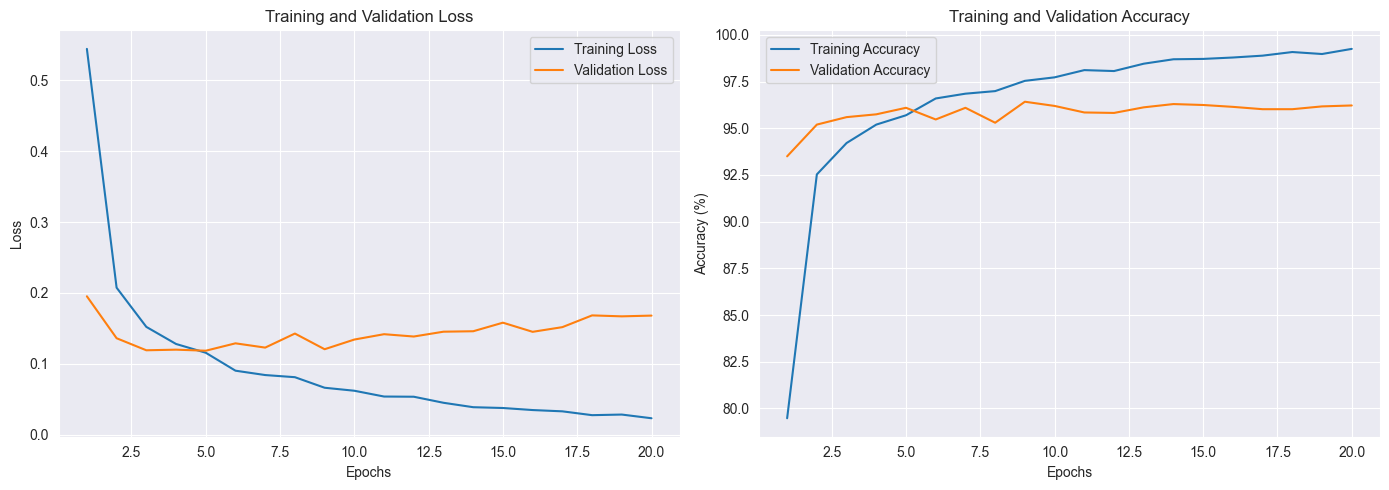

In [24]:
import matplotlib.pyplot as plt

print("--- Plotting Training and Validation Metrics ---")

# Ensure metrics were recorded during training
if not train_losses or not val_losses or not train_accuracies or not val_accuracies:
    print("Metrics lists are empty. Please ensure training loop in Cell 18 ran and populated these lists.")
else:
    epochs_range = range(1, NUM_EPOCHS + 1) # NUM_EPOCHS from Cell 2

    plt.figure(figsize=(14, 5))

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [25]:
import pandas as pd
import numpy as np

print("--- Generating Predictions on Test Set ---")

# Ensure model is in evaluation mode
model.eval()

all_predictions = []

# Disable gradient calculations for inference
with torch.no_grad():
    for i, batch in enumerate(test_loader): # test_loader was defined in Cell 15
        # Move all parts of the batch to the device
        batch_on_device = {}
        for key, value in batch.items():
            # The test batch from PatientDataset won't have a 'labels' key if labels=None was passed
            if key != 'labels': # Ensure we only move feature tensors
                 batch_on_device[key] = value.to(DEVICE)

        # Forward pass
        outputs = model(batch_on_device) # Model's forward takes the whole batch dictionary

        # Get the predicted class (index with the highest score)
        _, predicted_indices = torch.max(outputs.data, 1)
        all_predictions.extend(predicted_indices.cpu().numpy()) # Move to CPU and convert to numpy array

print(f"Generated {len(all_predictions)} predictions.")

# Convert numerical predictions back to original string labels
# target_label_encoder was fitted in Cell 6
if 'target_label_encoder' in globals() and target_label_encoder is not None:
    predicted_categories_str = target_label_encoder.inverse_transform(all_predictions)
    print("\nPredictions converted back to original string labels.")
else:
    print("ERROR: target_label_encoder not found or not fitted. Cannot convert predictions to string labels.")
    # As a fallback, you might have to use the raw predicted indices,
    # but the competition likely expects string labels.
    # Ensure Cell 6 was run correctly and target_label_encoder is available.
    predicted_categories_str = all_predictions # Fallback, not ideal


# Create the submission DataFrame
# test_patient_ids was stored in Cell 3 (Revised)
if len(test_patient_ids) == len(predicted_categories_str):
    submission_df = pd.DataFrame({
        'PatientID': test_patient_ids,
        'Admission_Category': predicted_categories_str
    })

    # Save the submission file
    submission_filename = 'submission.csv'
    submission_df.to_csv(submission_filename, index=False)
    print(f"\nSubmission file '{submission_filename}' created successfully.")
    print("First 5 rows of the submission file:")
    print(submission_df.head())
else:
    print(f"ERROR: Mismatch in length between test_patient_ids ({len(test_patient_ids)}) and predictions ({len(predicted_categories_str)}). Cannot create submission file.")


# Optional: Display value counts of predictions to see the distribution
print("\nDistribution of predicted categories in the submission:")
print(submission_df['Admission_Category'].value_counts(normalize=True) * 100 if 'submission_df' in globals() else "Submission DF not created.")

--- Generating Predictions on Test Set ---
Generated 5000 predictions.

Predictions converted back to original string labels.

Submission file 'submission.csv' created successfully.
First 5 rows of the submission file:
                              PatientID Admission_Category
0  b67ffa23-7762-46bb-a634-8a1b7c9d575e             Urgent
1  d6751089-e8a0-4771-9821-1c982d2fbccb             Urgent
2  f6423513-9ba1-43ac-a49e-2575339c0ee9             Urgent
3  7c6a5738-5c51-4a84-93e1-5e86a558edb3           Elective
4  00a0333e-1ccb-47cf-a58e-85589c01a7de          Emergency

Distribution of predicted categories in the submission:
Admission_Category
Urgent       61.16
Newborn      20.48
Emergency    13.28
Elective      5.08
Name: proportion, dtype: float64


In [26]:
from sklearn.metrics import accuracy_score, classification_report

print("--- Calculating Accuracy on Test Set (using actual labels from test.csv) ---")

# 1. Ensure you have the actual 'Admission_Category' from the original test_df
#    (Assuming 'test_df' loaded in Cell 3 still has this column)
if 'Admission_Category' in test_df.columns:
    actual_test_labels_str = test_df['Admission_Category']
    print(f"Found {len(actual_test_labels_str)} actual labels in test_df.")

    # 2. Encode these actual string labels using the target_label_encoder (from Cell 6)
    #    Make sure target_label_encoder is available and was fitted.
    if 'target_label_encoder' in globals() and target_label_encoder is not None:
        try:
            # Handle potential new labels in test_df['Admission_Category'] if they weren't in train
            # A robust way is to only consider labels known to the encoder
            # or re-fit the encoder on all known labels if this were a combined dataset.
            # For now, let's assume it should transform known labels or error on new ones.
            # A better approach for new labels would be to map them to a special 'unknown' category
            # if the encoder was set up for it, or filter them out for this accuracy calculation if they are truly new.

            # For simplicity, let's transform and see. If it errors, it means test.csv has categories
            # that were not in train.csv's target column.
            actual_test_labels_encoded = target_label_encoder.transform(actual_test_labels_str)
            print("Actual test labels encoded successfully.")

            # 3. Compare with model's predictions (all_predictions from Cell 20)
            # Ensure 'all_predictions' list/array is available from Cell 20
            if 'all_predictions' in globals() and all_predictions is not None:
                if len(actual_test_labels_encoded) == len(all_predictions):
                    test_accuracy = accuracy_score(actual_test_labels_encoded, all_predictions)
                    print(f"\nAccuracy on the 'test set' (using provided actual labels): {test_accuracy*100:.2f}%")

                    print("\nClassification Report for the 'test set':")
                    # Get string versions of actual and predicted for a more readable report
                    predicted_test_labels_str = target_label_encoder.inverse_transform(all_predictions)
                    print(classification_report(actual_test_labels_str, predicted_test_labels_str, labels=target_label_encoder.classes_))

                else:
                    print(f"ERROR: Length mismatch between actual test labels ({len(actual_test_labels_encoded)}) and predictions ({len(all_predictions)}).")
            else:
                print("ERROR: `all_predictions` not found. Please ensure Cell 20 was run.")
        except ValueError as e:
            print(f"ERROR during encoding actual test labels: {e}")
            print("This might mean your test.csv contains 'Admission_Category' values that were not present in the training set's 'Admission_Category'.")
            print("You might need to handle these unknown labels (e.g., by excluding them from this specific accuracy calculation or mapping them if your encoder strategy allows).")
    else:
        print("ERROR: `target_label_encoder` not found or not fitted. Cannot encode actual test labels.")
else:
    print("ERROR: 'Admission_Category' column not found in the loaded `test_df`.")
    print("Please ensure your test.csv was loaded correctly and contains this column if you wish to calculate test accuracy.")

print("\nReminder: This test accuracy is valid only if the 'Admission_Category' values in test.csv")
print("were NOT used in any part of the training process (including feature engineering that might touch test data).")

--- Calculating Accuracy on Test Set (using actual labels from test.csv) ---
Found 5000 actual labels in test_df.
Actual test labels encoded successfully.

Accuracy on the 'test set' (using provided actual labels): 96.60%

Classification Report for the 'test set':
              precision    recall  f1-score   support

    Elective       0.89      0.84      0.86       269
   Emergency       0.97      0.97      0.97       661
     Newborn       0.99      0.95      0.97      1077
      Urgent       0.96      0.98      0.97      2993

    accuracy                           0.97      5000
   macro avg       0.95      0.94      0.94      5000
weighted avg       0.97      0.97      0.97      5000


Reminder: This test accuracy is valid only if the 'Admission_Category' values in test.csv
were NOT used in any part of the training process (including feature engineering that might touch test data).


--- EDA: Distribution of a Numerical Feature (e.g., Age) ---


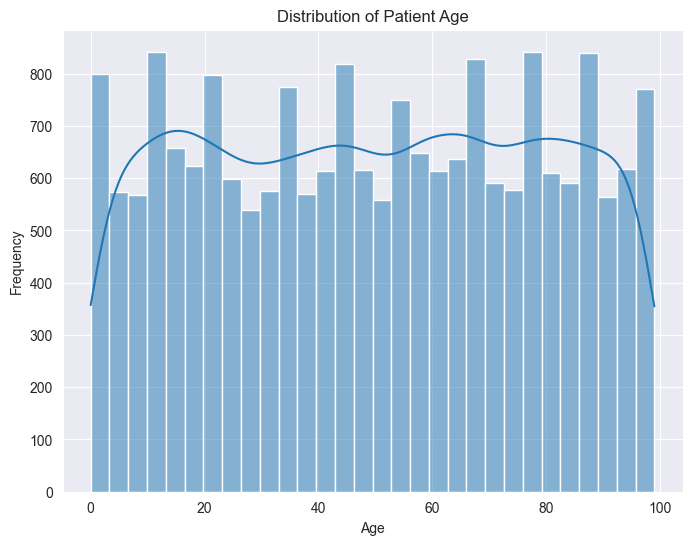

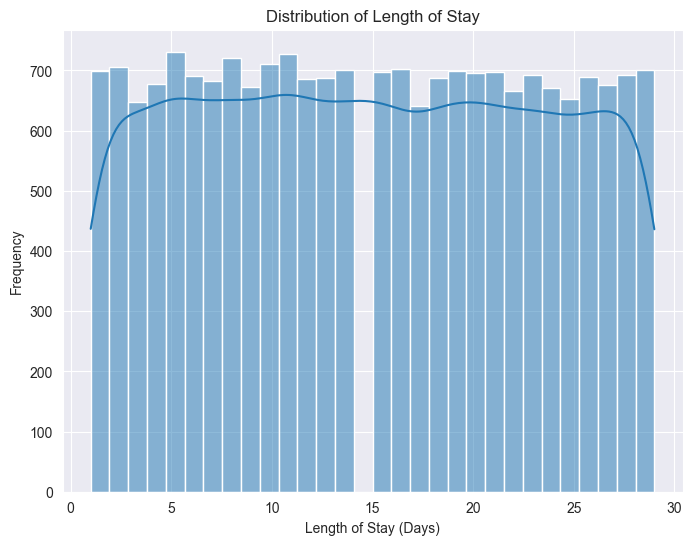

In [27]:
# Cell: EDA - Numerical Feature Distribution
import matplotlib.pyplot as plt
import seaborn as sns

print("--- EDA: Distribution of a Numerical Feature (e.g., Age) ---")
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='Age', kde=True, bins=30) # train_df is from Cell 3
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# You can repeat this for other important numerical features like 'Length_of_Stay'
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='Length_of_Stay', kde=True, bins=30)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

--- EDA: Distribution of a Categorical Feature (e.g., Gender) ---


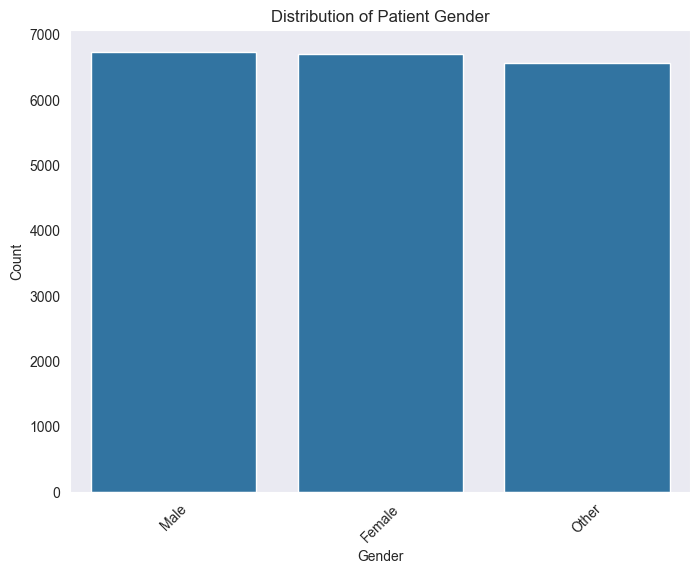

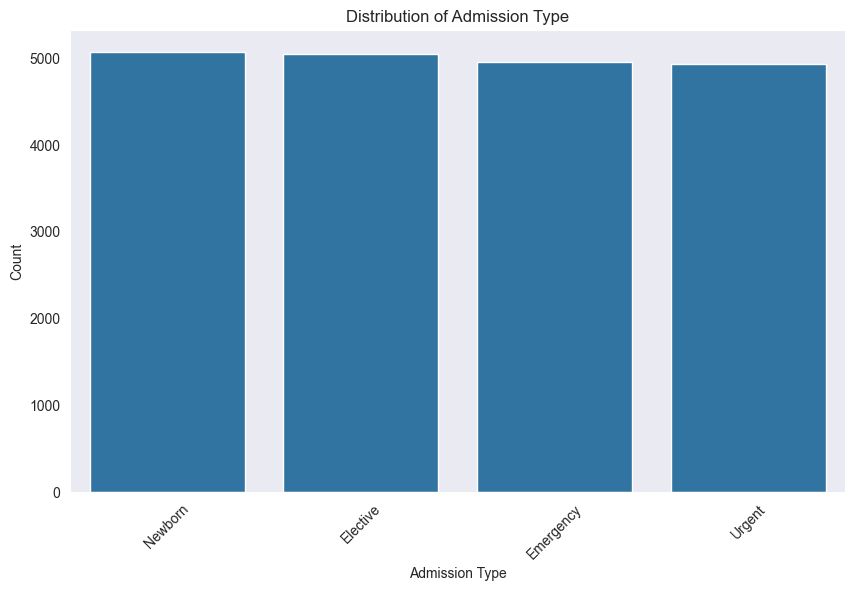

In [28]:
# Cell: EDA - Categorical Feature Distribution
print("--- EDA: Distribution of a Categorical Feature (e.g., Gender) ---")
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='Gender', order=train_df['Gender'].value_counts().index) # train_df is from Cell 3
plt.title('Distribution of Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# You can repeat this for other key categorical features:
# 'Admission_Type', 'Ethnicity', 'Comorbidities', 'Insurance', 'Follow_Up'
# Example for 'Admission_Type':
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='Admission_Type', order=train_df['Admission_Type'].value_counts().index)
plt.title('Distribution of Admission Type')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

--- EDA: Numerical Feature (Age) vs. Target (Admission_Category) ---


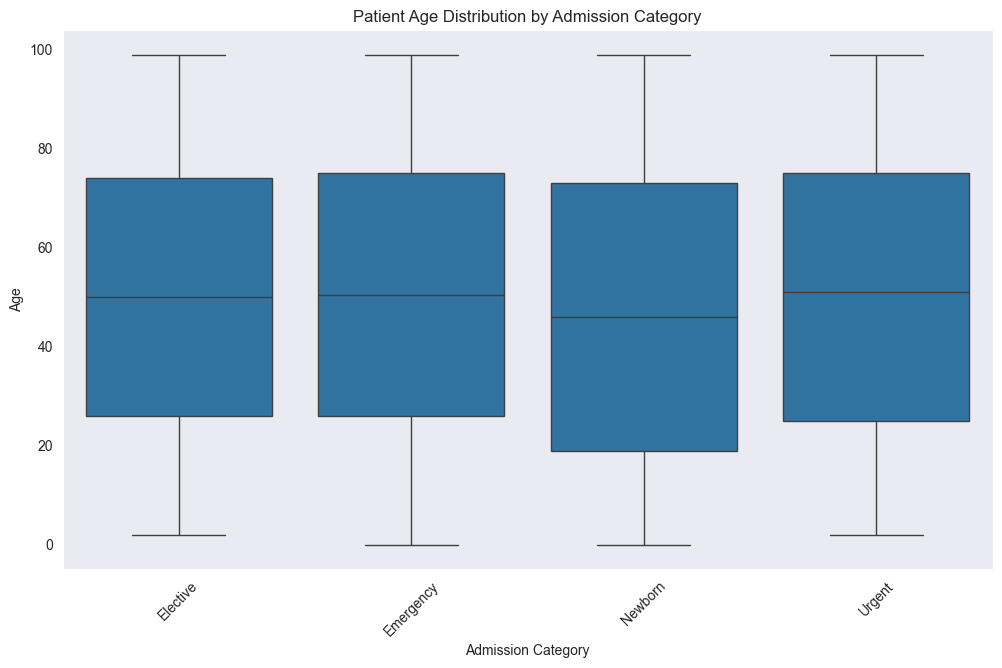

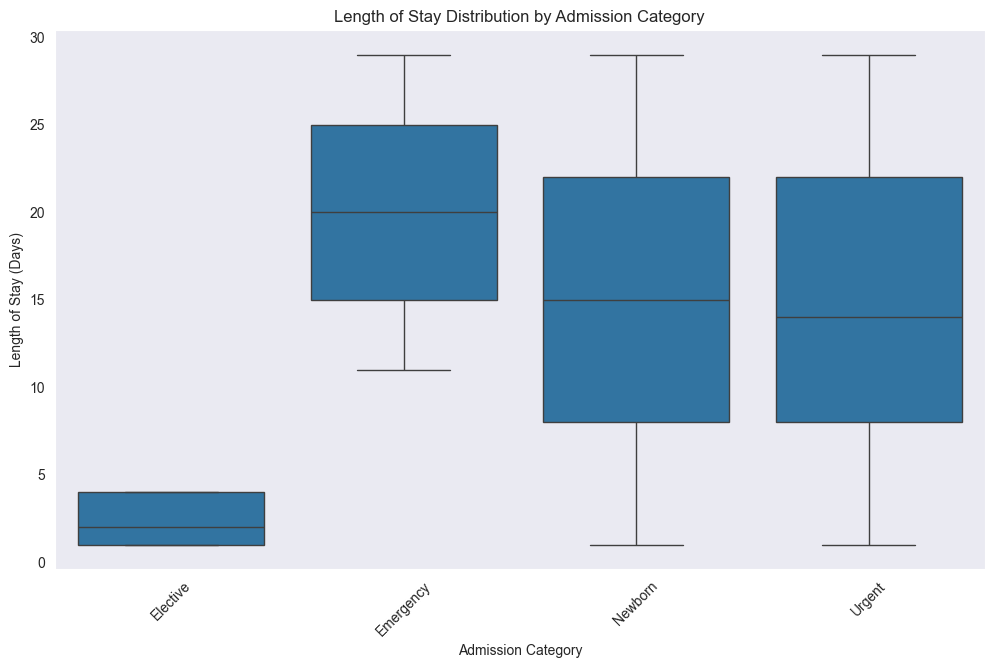

In [29]:
# Cell: EDA - Numerical Feature vs. Target
print("--- EDA: Numerical Feature (Age) vs. Target (Admission_Category) ---")
plt.figure(figsize=(12, 7))
sns.boxplot(data=train_df, x='Admission_Category', y='Age', order=target_label_encoder.classes_) # train_df from Cell 3, target_label_encoder from Cell 6
plt.title('Patient Age Distribution by Admission Category')
plt.xlabel('Admission Category')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Repeat for 'Length_of_Stay'
plt.figure(figsize=(12, 7))
sns.boxplot(data=train_df, x='Admission_Category', y='Length_of_Stay', order=target_label_encoder.classes_)
plt.title('Length of Stay Distribution by Admission Category')
plt.xlabel('Admission Category')
plt.ylabel('Length of Stay (Days)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

--- EDA: Categorical Feature (Gender) vs. Target (Admission_Category) ---


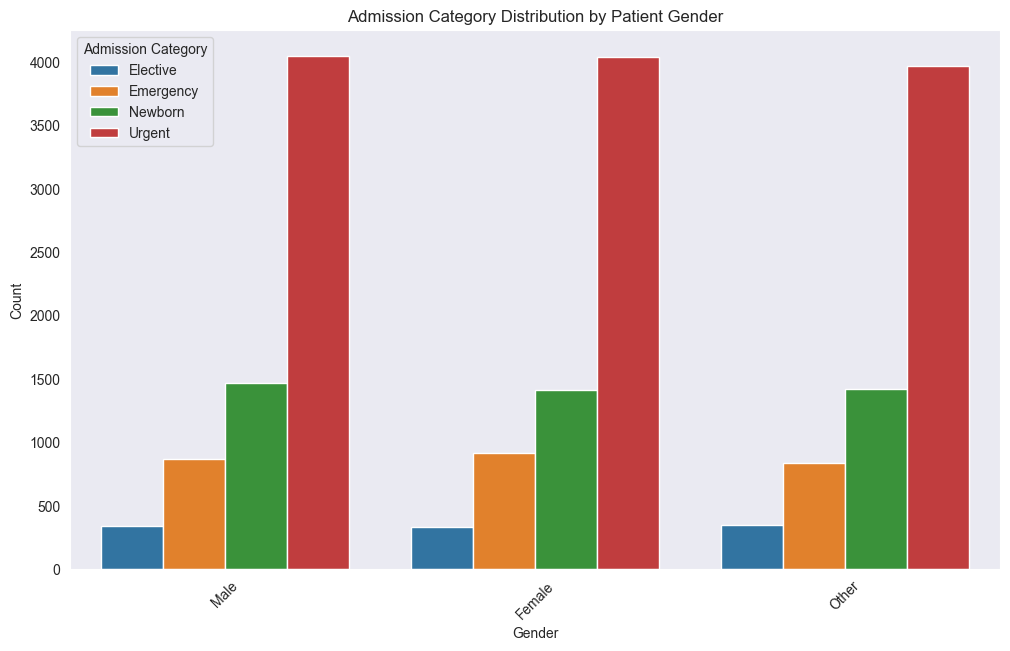

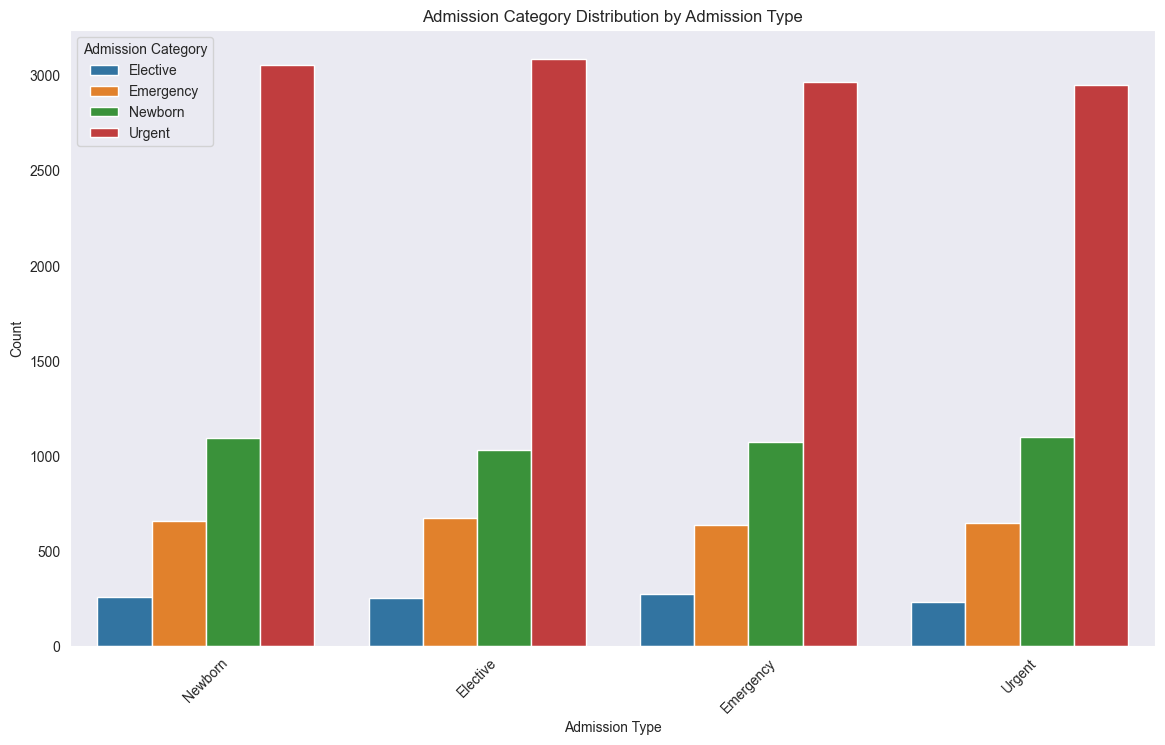

In [30]:
# Cell: EDA - Categorical Feature vs. Target
print("--- EDA: Categorical Feature (Gender) vs. Target (Admission_Category) ---")
plt.figure(figsize=(12, 7))
sns.countplot(data=train_df, x='Gender', hue='Admission_Category', hue_order=target_label_encoder.classes_, order=train_df['Gender'].value_counts().index) # train_df from Cell 3
plt.title('Admission Category Distribution by Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Admission Category')
plt.grid(axis='y')
plt.show()

# Repeat for another categorical feature, e.g., 'Admission_Type' vs 'Admission_Category'
plt.figure(figsize=(14, 8))
sns.countplot(data=train_df, x='Admission_Type', hue='Admission_Category', hue_order=target_label_encoder.classes_, order=train_df['Admission_Type'].value_counts().index)
plt.title('Admission Category Distribution by Admission Type')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Admission Category')
plt.grid(axis='y')
plt.show()

--- Model Performance: Confusion Matrix for Test Set ---


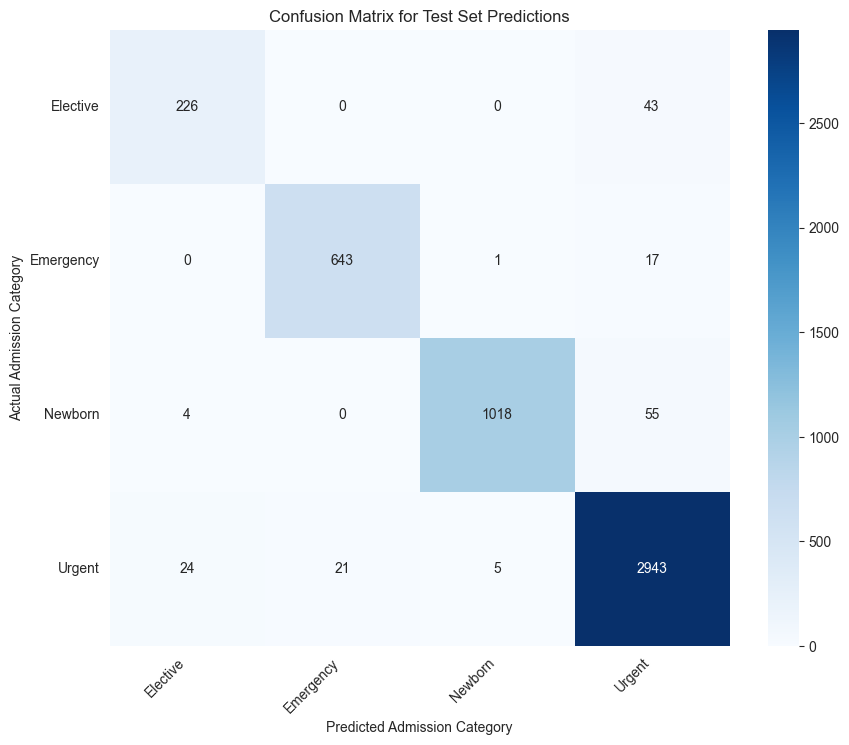

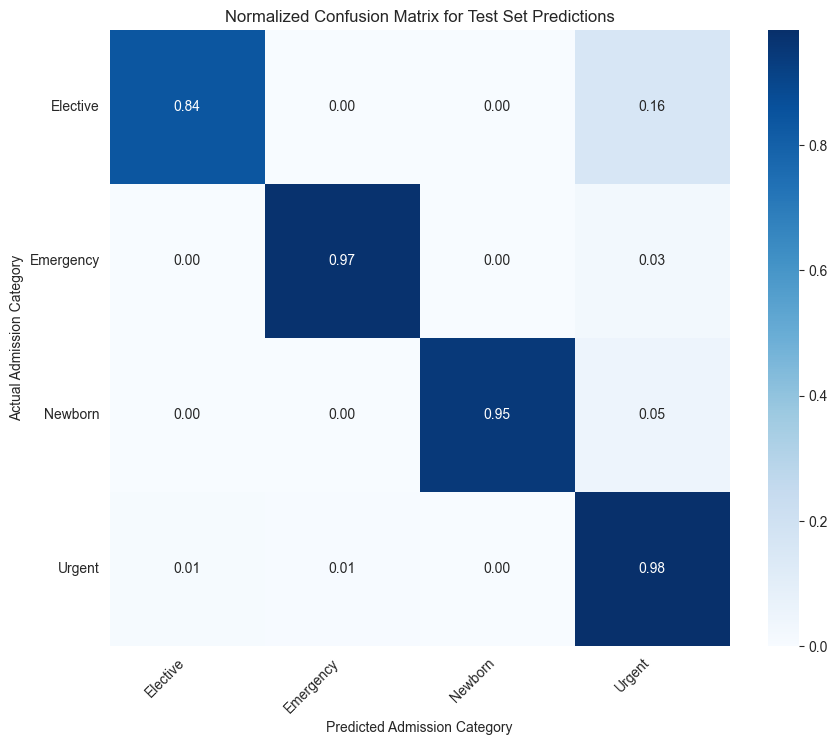

In [31]:
# Cell: Model Performance - Confusion Matrix
from sklearn.metrics import confusion_matrix
import itertools

print("--- Model Performance: Confusion Matrix for Test Set ---")

# Ensure these variables are available from Cell 21:
# actual_test_labels_str (original string labels from test_df)
# predicted_test_labels_str (model's string predictions for test set)
# target_label_encoder (fitted in Cell 6, to get class names in order)

if 'actual_test_labels_str' in globals() and 'predicted_test_labels_str' in globals():
    cm = confusion_matrix(actual_test_labels_str, predicted_test_labels_str, labels=target_label_encoder.classes_)
    class_names = target_label_encoder.classes_

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for Test Set Predictions')
    plt.ylabel('Actual Admission Category')
    plt.xlabel('Predicted Admission Category')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

    # Normalized Confusion Matrix (shows percentages)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix for Test Set Predictions')
    plt.ylabel('Actual Admission Category')
    plt.xlabel('Predicted Admission Category')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

else:
    print("Could not generate confusion matrix: 'actual_test_labels_str' or 'predicted_test_labels_str' not found.")
    print("Please ensure Cell 21 was run successfully and these variables were created.")